# Fine-tuning of ChemBERTa-2 on balanced dataset


## Environment setup

## Imports and parameters setting

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from typing import List

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from simpletransformers.classification import ClassificationModel, ClassificationArgs


2024-04-03 12:53:01.889550: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 12:53:01.892873: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 12:53:01.929082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 12:53:02.537783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'pydantic'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/home/parsa/smiles_classification/bert-loves-chemistry


In [ ]:
# set the logging directories
project_name = "ChemBERTA_ict"
output_path = '/home/parsa/smiles_classification/LLM_Fine_balanced_Tuning_Molecular_Properties_output'
model_name = 'model_balanced_v3_dataset_facebook'

model_folder = os.path.join(output_path, model_name)

evaluation_folder = os.path.join(output_path, model_name + '_evaluation')
if not os.path.exists(evaluation_folder):
    os.makedirs(evaluation_folder)

# set the parameters
EPOCHS = 200
BATCH_SIZE = 100
patience = 30
optimizer = "AdamW"
learning_rate = 0.00001
manual_seed = 112
print(model_folder)

/home/parsa/smiles_classification/LLM_Fine_balanced_Tuning_Molecular_Properties_output/model_balanced_v3_dataset_facebook


## Dataset Loading & Splitting

In [ ]:
def plot_classes_distribution(dataframes, class_column, colors, figure_title=None,  plot_titles=None, figsize=(15, 6), equal_y_scale=False, fig_output_path=None):
    """
    Function plotting classes distribution in dataframe(s).

    Args:
        dataframes (list of dataframes): list of dataframes to plot the classes distribution
        class_column (str): column in dataframes identifying the class
        figure title (str): optional
        plot_titles (list of str): optional
        colors (list of str): colors of the bars in each plot
        figsize (tuple of int): figure width and height
        equal_y_scale (bool): whether the plots, should have equal y scale
        fig_output_path (str): optional
    """

    subplots_number = len(dataframes)
    dataframes_value_counts = []


    plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(1,subplots_number, figsize=figsize)

    if figure_title:
        fig.suptitle(figure_title, fontsize=22, y = 1, x = 0.52)

    for i, df in enumerate(dataframes):
        df_value_counts = df[class_column].value_counts().sort_index()

        if len(dataframes) == 1:
            axs.bar(df_value_counts.index, df_value_counts, color=colors[0], alpha=0.7)

            if plot_titles:
                axs.set_title(plot_titles)

        else:
            axs[i].bar(df_value_counts.index, df_value_counts, color=colors[i], alpha=0.7)

            if plot_titles:
                axs[i].set_title(plot_titles[i])

        dataframes_value_counts.append(df_value_counts)

    fig.tight_layout(pad=2.0)

    if equal_y_scale:
        y_min_plots = []
        y_max_plots = []

        for i, ax in enumerate(axs):
            y_min, y_max = axs[i].get_ylim()
            y_min_plots.append(y_min)
            y_max_plots.append(y_max)

        for i, ax in enumerate(axs):
            axs[i].set_ylim(min(y_min_plots), max(y_max_plots))

    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")

    plt.show()

    return dataframes_value_counts

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('../Data_v3.csv').rename({'Unnamed: 1':'labels','SMILE':'text'},axis=1)
data.head()

,text,labels
0,C=CC(=O)NC(=O)NC1(CC2CC3CC(C2)C1)C3,0
1,CC=1C=CC(=CC1)C(=O)C=2OC=CC2NC(=O)C=C,0
2,CN(C)C1=NC(Cl)=C(CNC(=O)C=C)S1,0
3,C=CC(=O)N1CN(CC=2C=CC=CC2)C(=O)C1,0
4,C=CC(=O)NCC(=O)N1CCC=2C=CC=CC2C1,0


<Axes: >

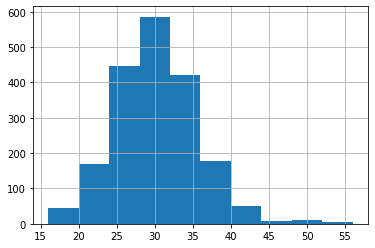

In [ ]:
data.text.str.len().hist()

In [ ]:
data.text.str.len().max()

56

In [ ]:
pos = data[data['labels']==1]
neg = data[data['labels']==0]

<Axes: >

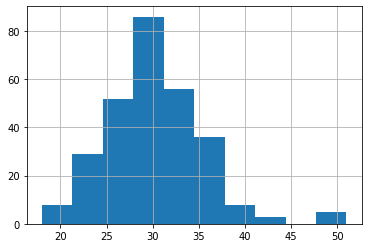

In [ ]:
pos.text.str.len().hist()

<Axes: >

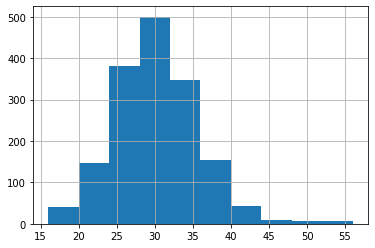

In [ ]:
neg.text.str.len().hist()

In [ ]:
pos.head()

,text,labels
1636,FC1(F)C2CC3CC1CC(C3)(C2)NC(=O)C=C,1
1637,C=CC(=O)NC=1C=CC=C(C1)C(=O)N2CCC=3C=CC=CC23,1
1638,CC(C)N1N=C(C)C(NC(=O)C=C)=C1C,1
1639,CC1=NC(=NO1)C2CC3CCC(C2)N3C(=O)C=C,1
1640,C=CC(=O)NC=1C=CC=C(C1)N2CCOCC2=O,1


In [ ]:
shuffled_pos = pos.sample(frac=1)
print(pos.shape)
shuffled_pos.head()

(283, 2)


,text,labels
1649,CC=1C=CC=C2C(CCCOC12)N(C3CC3)C(=O)C=C,1
1724,CC1(CCN(CC1)C(=O)C=C)N2CCOCC2,1
1793,CC1C(CC(=O)N1CC=2C=CC=CC2)NC(=O)C=C,1
1640,C=CC(=O)NC=1C=CC=C(C1)N2CCOCC2=O,1
1859,CS(=O)(=O)NCC1COCCN1C(=O)C=C,1


In [ ]:
pos_test = shuffled_pos[:28]
pos_val = shuffled_pos[28:56]
pos_train = shuffled_pos[56:]
print(pos_test.shape,pos_val.shape,pos_train.shape)

(28, 2) (28, 2) (227, 2)


In [ ]:
shuffled_neg = neg.sample(frac=1)
print(neg.shape)
neg_test = shuffled_neg[:28]
neg_val = shuffled_neg[28:56]
neg_train = shuffled_neg[56:283]
print(neg_test.shape,neg_val.shape,neg_train.shape)

(1636, 2)
(28, 2) (28, 2) (227, 2)


<Axes: >

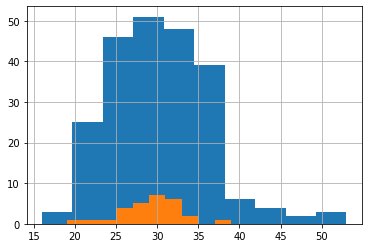

In [ ]:
neg_train.text.str.len().hist()
neg_test.text.str.len().hist()

<Axes: >

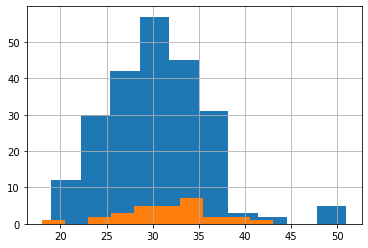

In [ ]:
pos_train.text.str.len().hist()
pos_test.text.str.len().hist()

In [ ]:
train_df = pd.concat([neg_train,pos_train],ignore_index=True)
test_df = pd.concat([neg_test,pos_test],ignore_index=True)
valid_df = pd.concat([neg_val,pos_val],ignore_index=True)
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [ ]:
print(f"The number of molecules in the train set {train_df.shape[0]}")
print(f"The number of molecules in the valid set {valid_df.shape[0]}")
print(f"The number of molecules in the test set {test_df.shape[0]}")
train_df.head()

The number of molecules in the train set 454
The number of molecules in the valid set 56
The number of molecules in the test set 56


,text,labels
54,C=CC(=O)N1CCN(CC1)C2CCNC(=O)CC2,0
407,FC(F)(F)C1CCN(CC21CCOCC2)C(=O)C=C,1
90,CC1CC2(CN1C(=O)C=C)CCOCC2,0
345,C=CC(=O)N1CCCN(CC1)C(=O)C2CCCO2,1
186,COC=1C=CC(=CN1)[C@@H]2OCC[C@H]2NC(=O)C=C |&1:8...,0


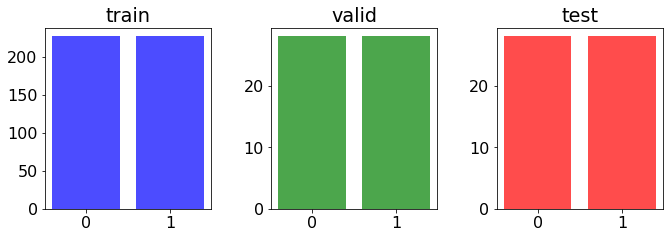

In [ ]:
value_counts = plot_classes_distribution(dataframes=[train_df, valid_df, test_df], class_column='labels', colors=['blue', 'green', 'red'], figure_title=None,  plot_titles=['train', 'valid', 'test'], figsize=(10, 4), equal_y_scale=False, fig_output_path=None)

## Fine-tuning

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# log in to Weights & Biases for experiment tracking
!wandb login

wandb: Currently logged in as: mparsa (mypersonalteam). Use `wandb login --relogin` to force relogin


In [ ]:

# configure training
classification_args = {'evaluate_each_epoch': True,
                       'evaluate_during_training_verbose': False,
                       'evaluate_during_training' : True,
                       'best_model_dir' : model_folder,
                       'no_save': False,
                       'save_eval_checkpoints': False,
                       'save_model_every_epoch': False,
                       'save_best_model' : True,
                       'save_steps': -1,
                       'num_train_epochs': EPOCHS,
                       'use_early_stopping': True,
                       'early_stopping_patience': patience,
                       'early_stopping_delta': 0.0001,
                       'early_stopping_metrics': 'eval_loss',
                       'early_stopping_metrics_minimize': True,
                       'early_stopping_consider_epochs' : True,
                       'fp16' : False,
                       'optimizer' : optimizer,
                    #    'adam_betas' : (0.95, 0.999),
                     #   'learning_rate' : 5e-5,
                       'manual_seed': manual_seed,
                       'train_batch_size' : BATCH_SIZE,
                       'eval_batch_size' : BATCH_SIZE,
                       'logging_steps' : 1, #len(train_df) / BATCH_SIZE,
                       'auto_weights': True, # change to true
                       # 'wandb_project': project_name,
                       'overwrite_output_dir':True,
                       "use_multiprocessing": False,
                        'use_multiprocessing_for_evaluation': False,
                        'multiprocessing_chunksize':1,
                       # 'wandb_kwargs': wandb_kwargs
                      }
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# sweep_config = {
#     "name": "vanilla-sweep-batch-16",
#     "method": "bayes",
#     "metric": {"name": "precision", "goal": "maximize"},
#     "parameters": {
#         "num_train_epochs": {"min": 1, "max": 40},
#         "learning_rate": {"min": 0.0, "max": 5e-5},
#     },
#     "early_terminate": {"type": "hyperband", "min_iter": 6,},
# }
# sweep_id = wandb.sweep(sweep_config, project="RTE - Hyperparameter Optimization")
model = ClassificationModel('xlmroberta', 'FacebookAI/xlm-roberta-large', args=classification_args, cuda_device=1, use_cuda=True
                            # ,sweep_config=wandb.config,
                            )

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/parsa/conda/envs/p2/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:484: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [ ]:
# Train the model and log on wandb
from sklearn.metrics import precision_score
def train():
    # Initialize a new wandb run
    wandb.init()
    model = ClassificationModel('roberta', 'DeepChem/ChemBERTa-77M-MLM', args=classification_args, cuda_device=1,sweep_config=wandb.config,)
    model.train_model(train_df, eval_df=valid_df, output_dir=model_folder,
                                precision=lambda truth, predictions: precision_score(
                truth, [round(p) for p in predictions]
            ),)
    wandb.join()
wandb.agent(sweep_id, train)

## Evaluation

In [ ]:
# load the best model
model = ClassificationModel('roberta', model_folder, args=classification_args,use_cuda=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:

# evaluate the best model
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score, precision=sklearn.metrics.precision_score)
print(result)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


wandb: Currently logged in as: mparsa (mypersonalteam). Use `wandb login --relogin` to force relogin


INFO:simpletransformers.classification.classification_model:{'mcc': -0.10889310129609416, 'accuracy': 0.44642857142857145, 'f1_score': 0.4918032786885246, 'tp': 15, 'tn': 10, 'fp': 18, 'fn': 13, 'auroc': 0.49234693877551017, 'auprc': 0.5555089290072116, 'acc': 0.44642857142857145, 'precision': 0.45454545454545453, 'eval_loss': 0.6937013864517212}


{'mcc': -0.10889310129609416, 'accuracy': 0.44642857142857145, 'f1_score': 0.4918032786885246, 'tp': 15, 'tn': 10, 'fp': 18, 'fn': 13, 'auroc': 0.49234693877551017, 'auprc': 0.5555089290072116, 'acc': 0.44642857142857145, 'precision': 0.45454545454545453, 'eval_loss': 0.6937013864517212}


In [ ]:
# save the results
test_eval_results_path = os.path.join(evaluation_folder, 'test_eval_results.txt')
with open(test_eval_results_path, 'w+', encoding='latin-1') as file:
    file.write(str(result))

In [ ]:
# save the predictions
def make_predictions_df(test_df, model_outputs):
    predictions_df = test_df.copy()
    predictions_df['class_0_probability'] = model_outputs[:, 0]
    predictions_df['class_1_probability'] = model_outputs[:, 1]
    predictions_df['y_pred'] = np.argmax(model_outputs, axis=1)
    return predictions_df

In [ ]:
predictions_df = make_predictions_df(test_df, model_outputs)
predictions_df_path = os.path.join(evaluation_folder, 'test_v2_predictions_df.csv')
predictions_df.to_csv(predictions_df_path)
predictions_df.head()

,text,labels,class_0_probability,class_1_probability,y_pred
0,C(C(NCC1=CC=CC=C1)=O)(C(C1=CC=CC=C1)C)CC(=O)O,0,0.399203,-0.460402,0
1,C=CC(=O)N1CCN(CC1)S(=O)(=O)CC=2C=CON2,0,-0.460174,0.499814,1
2,C12=C(C(N3C(CC)CCCC3)=O)C=NN1C(C(F)(F)F)=CC(C1...,0,0.112286,-0.124490,0
3,COC1CC(NC(=O)C=C)C1(C)C,0,0.173829,-0.123947,0
4,S(NC1=CC(C)=C(C)C=C1)(C1=CC(C(F)(F)F)=CC=C1)(=...,0,0.256600,-0.363470,0


In [ ]:
import seaborn as sns
from sklearn.metrics import *

def plot_prediction_distribution(pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Probability')
    plt.ylabel('#')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')

def plot_AUROC(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    fpr, tpr, thresholds = roc_curve(GT_array, pred_array)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.4f)'  % ('Model', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def plot_precision_recall_curve(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Model', average_precision_score(GT_array,pred_array)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_f1_tresh(GT_array, pred_array, fig_output_path=None):
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    f1 = calc_f1(precision, recall)
    plt.figure(figsize=(6,4))
    plt.plot(f1[:-1], thresholds)
    plt.xlabel('F1 score')
    plt.ylabel('Treshold')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def plot_confusion_matrix(cf_matrix, classes, title=None, percentage=True, font_size=16, figsize=(8,8), fig_output_path=None):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    plt.rcParams.update({'font.size': 16})

    if title:
        fig.suptitle(title, fontsize=22, y = 1, x = 0.52)

    if percentage == True:
        sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt=".0%", cbar=False, square=True, ax=axs, cmap="Blues")
    else:
        sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d", cbar=False, square=True, ax=axs, cmap="Blues")
    axs.set_xlabel("Predicted labels", fontsize=20)
    axs.set_ylabel("True labels",fontsize=20)
    fig.tight_layout(pad=1.0)

    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")

    plt.show()


def evaluate(GT_array, pred_array, output_folder_path=None):
    if output_folder_path:
        prediction_distribution_output = os.path.join(output_folder_path, 'prediction_distribution.tiff')
        AUROC_output = os.path.join(output_folder_path, 'AUROC.tiff')
        precision_recall_output = os.path.join(output_folder_path, 'precision_recall.tiff')
        t1_tresh_output = os.path.join(output_folder_path, 't1_tresh.tiff')

    else:
        prediction_distribution_output = None
        AUROC_output = None
        precision_recall_output = None
        t1_tresh_output= None

    plot_prediction_distribution(pred_array, fig_output_path=prediction_distribution_output)
    plot_AUROC(GT_array, pred_array, fig_output_path=AUROC_output)
    plot_precision_recall_curve(GT_array, pred_array, fig_output_path=precision_recall_output)
    plot_f1_tresh(GT_array, pred_array, fig_output_path=t1_tresh_output)

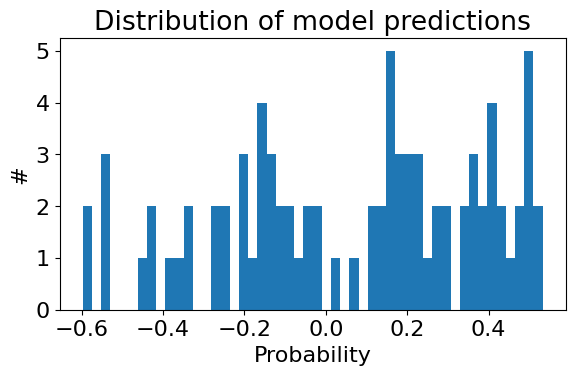

Model prediction min: -0.598
Model prediction max: 0.533


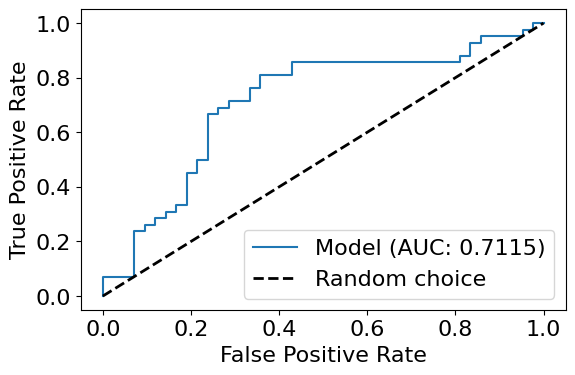

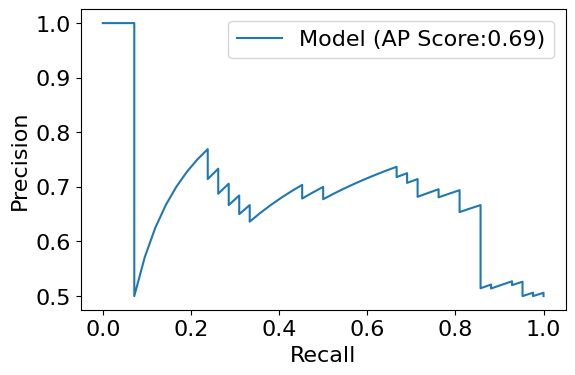

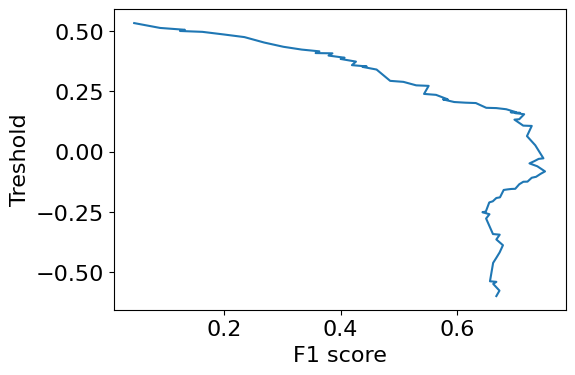

In [ ]:
evaluate(predictions_df['labels'], predictions_df['class_1_probability'], output_folder_path=evaluation_folder)

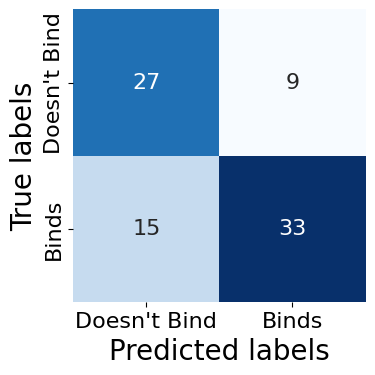

In [ ]:
confusion_matrix = np.array([[result['tn'], result['fn']], [result['fp'], result['tp']]])
plot_confusion_matrix(confusion_matrix, classes=["Doesn't Bind", "Binds"], title=None, percentage=False, font_size=16, figsize=(4,4), fig_output_path=None)

## Predicting

In [ ]:
import pandas as pd
valid_df = pd.read_csv('/home/parsa/smiles_classification/data_validation.csv')
valid_df

,SMILES,RESULT
0,C=CC(=O)NC(=O)NC1(CC2CC3CC(C2)C1)C3,0
1,CC=1C=CC(=CC1)C(=O)C=2OC=CC2NC(=O)C=C,0
2,CN(C)C1=NC(Cl)=C(CNC(=O)C=C)S1,0
3,C=CC(=O)N1CN(CC=2C=CC=CC2)C(=O)C1,0
4,C=CC(=O)NCC(=O)N1CCC=2C=CC=CC2C1,0
5,CN(C)S(=O)(=O)C=1C=CC=2CN(CC2C1)C(=O)C=C,0
6,CN1N=CC=2C=CC(CNC(=O)C=C)=CC12,0
7,CC(NC(=O)C=C)C(=O)N1CCC=2C=CC=CC12,0
8,C=CC(=O)N1CCN(CC1)S(=O)(=O)CC=2C=CON2,0
9,C=CC(=O)NCC=1C=C2OCCCN2N1,0


In [ ]:
pd.read_csv('/home/parsa/smiles_classification/Test-1.csv').rename({'Results':'RESULT'},axis=1)

,SMILES,RESULT
0,NC1=C2C(C=CC=C2)=C(S([O-])(=O)=O)C=C1/N=N/C(C=...,1
1,O=C(C1=C2C=CC=C1)C(SCCO)=C(SCCO)C2=O,1
2,NCCCNC(C=CC1=C2C(C3=C(C=CC(O)=C34)O)=NN1CCNCCO...,1
3,O=C(C1=CC(O)=C(O)C(O)=C1)O[C@H]2[C@@H](C3=CC(O...,1
4,O=C1C=C(C2=CC=CC=C2)OC3=C1C(O)=C(C(O)=C3)O,1
5,O=C(C=C(C1=CC=CC=C1)O2)C(C2=C3)=C(O)C(O)=C3O[C...,1
6,OC1=C(C2=CC=C(O)C(O)=C2)OC3=C(C(O)=CC(O)=C3)C1=O,1
7,C[C@@]12[C@@]3(C(COC(CC(C)C)=O)=O)[C@](O[C@H](...,1
8,OC1=C(SSC2=C(C=CC=C3)C3=CC=C2O)C4=CC=CC=C4C=C1,1
9,OC1=C(CC2=C(O)C(Cl)=CC(Cl)=C2Cl)C(Cl)=C(Cl)C=C1Cl,1
